
#A Neural Probabilitic Language Model...'

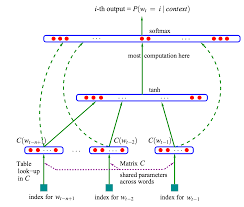

In [13]:
import string
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('/content/sample_data/names.txt', 'r').read().splitlines()

In [3]:

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print('stoi=>', stoi)
print('itos=>', itos)

stoi=> {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos=> {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
blocksiz = 3
X, Y = [], []
for w in words:
    contxt = [0] * blocksiz
    for ch in w + '.':
        ix = stoi[ch]
        X.append(contxt)
        Y.append(ix)
        contxt = contxt[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

#Parameters

In [5]:
# Parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)
para = [C, w1, b1, w2, b2]

#Num Parameters

In [12]:
sum(p.nelement() for p in para)

3481

In [6]:
#make Reuquared Grad. otherwise ran into error for not reqared grad
for p in para:
    p.requires_grad = True

In [7]:
#creating mini batch to train so itll be quick rather than train the whole dataset
ix = torch.randint(0, X.shape[0], (32,))
ix

tensor([198584, 185958,  92492, 165284, 208726, 113400, 198503, 125953, 167853,
        222840,  78885, 120827, 203853,  92791, 138818, 183366, 165377, 189731,
         78188, 172091, 209702,    785,  16368, 134067,  58028, 147351, 194920,
         59963,  81894,  51376,  31322, 136272])

# Fine Tuning Learning rate / Learning Decay

In [8]:
#learning Rate Exponent
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

#Training
   + Forward Pass
   + Backward Pass
   + Loss Calculation
   + Tracking Learning Rate

In [9]:
## since it got 1m 3s to train we can Use mini batch Randomly select by Dataset

#track learning rate stars || we figurout good learning rante==0.1 #according to stat
#lri = []
#losses = []

for i in range(100):
    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    #Forward Pass
    emb = C[X[ix]]#using mini batch
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y[ix])#using mini batch

    #Backward Pass
    for p in para:
        p.grad = None
    loss.backward()

    #update
    #lr = 0.1 #10**-1 || after itrations Learning rate decay
    lr = 0.01

    for p in para:
        p.data += -lr * p.grad

    #track stats Learning rate fineTune
    #lri.append(lre[i])
    #losses.append(loss.item())

print(f'Loss: {loss.item()}')

## After using mini batch to train its almost instant

## after learing rt finetune decrease 2.8 to 2.5 Loss

Loss: 10.38977336883545


In [ ]:
# Looking at the stat, the fair Learning
# Rate Would be -1.0..-0.5 which is [0.1]
# So now  we've Confidence/Stats so we set learning rate to == 0.1
plt.plot(lri, losses)

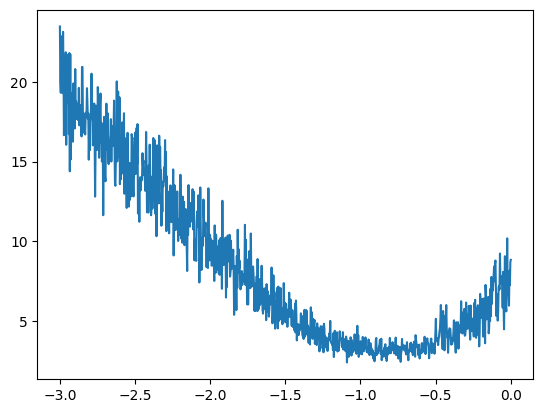

# However When we've Lots of parameters >1000or10000, it'll easyly Cuas to OVERFIT
   * and More Parameters Mean **Overfittin **and Overfitting Would  *lower the Loss Very Very low As Long As 0*
   
   * But It's cos the Loss is low it didnt mean Model work well, Its just memarizing the Training Data for **Verbatim**[in exactly the same words as were used originally.]
   
   * And if you try to **sample from **you'll only ***Get exactly as they are in the training set***, *You wont get any **NEW DATA**
   
   * to avoid that overfitting and loss thing we *split our Training DataSet to 3 Splits  
      + **Training** split %80
      + **Dev/ Validation** split 10%
      + **Test** split 10%

#Buiding the Dataset..

In [14]:
def buildDatset(words):
    blocksiz = 3
    X, Y = [], []
    for w in words:
        contxt = [0] * blocksiz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(contxt)
            Y.append(ix)
            contxt = contxt[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xTrain, yTrain = buildDatset(words[:n1])
xDev, yDev = buildDatset(words[n1:n2])
xTest, yTest = buildDatset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
n1

25626

In [17]:
n2

28829

In [19]:
n2- n1 #words for Dev set

3203

In [20]:
len(words) - n2 #for Test set

3204

#Let's Train With Split Build Dataset shall we
   * insted using X, Y
   * Now we use Split xTrain, yTrain

In [21]:
xTrain.shape , yTrain.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [39]:
#//# Parameters
#//#ALso The para IS Scaled 100w1w2-->300w1w2 also b1b2
#//g = torch.Generator().manual_seed(2147483647)
#//C = torch.randn((27, 2), generator=g)
#//w1 = torch.randn((6, 300), generator=g)
#//b1 = torch.randn((300), generator=g)
#//w2 = torch.randn((300, 27), generator=g)
#//b2 = torch.randn((27), generator=g)
#//para = [C, w1, b1, w2, b2]

+ Reshaping the dim of input layer,,2--->10 dim.

In [94]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 15), generator=g)
w1 = torch.randn((45, 200), generator=g)#cos we've 15dim 3input layers ==15x3=45
b1 = torch.randn((200), generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)
para = [C, w1, b1, w2, b2]

In [95]:
sum(p.nelement() for p in para)

15032

In [96]:
#make Reuquared Grad. otherwise ran into error for not reqared grad
for p in para:
    p.requires_grad = True

In [97]:
#creating mini batch to train so itll be quick rather than train the whole dataset
ix = torch.randint(0, X.shape[0], (32,))
ix

tensor([ 66369,   6193,  31429,  55167,   9674, 211029,  44394,  28915, 110031,
        182711,  57297, 195523, 121959, 147612, 178277,  90227,  10590, 107939,
         22332, 172592, 123802,  67310, 150523, 219765, 161533, 125588,  19113,
        128347, 202063, 111337,  89687, 162350])

In [43]:
#learning Rate Exponent
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

#Change/Use X ---> xTrain, Y ----> yTrain

In [104]:
lri = []
lossesi = []
stepi = []

In [100]:
## since it got 1m 3s to train we can Use mini batch Randomly select by Dataset

#track learning rate stars || we figurout good learning rante==0.1 #according to stat
#lri = []
#lossesi = []
#stepi = []

for i in range(200000):
    #minibatch
    ix = torch.randint(0, xTrain.shape[0], (32,))
    #Forward Pass
    emb = C[xTrain[ix]]#using mini batch
    h = torch.tanh(emb.view(-1, 45) @ w1 + b1) #now we've 45dim
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, yTrain[ix])#using mini batch

    #Backward Pass
    for p in para:
        p.grad = None
    loss.backward()

    #update
    #lr = 0.1 #10**-1 || after itrations Learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    #track stats Learning rate fineTune
    #lri.append(lre[i])
    stepi.append(i)
    lossesi.append(loss.log10().item())

print(f'Loss: {loss.item()}')

## After using mini batch to train its almost instant

## after learing rt finetune decrease 2.8 to 2.5 Loss

Loss: 2.2646119594573975


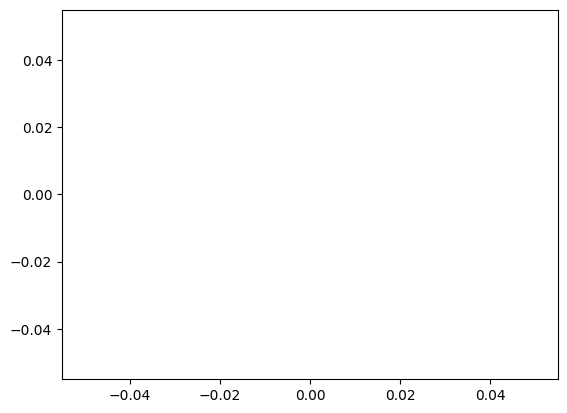

In [105]:
plt.plot(stepi, lossesi)

# So Training And Dev Loss are almost Equal So we are not Overfitting
  + also this calles **Underfitting**
  + so We can Deal with Underfitting Scaling the parameters..

#I Beat the shit out of 2.12 and 2.17 Loss
####kind of but im gassed

In [102]:
#Evaluating Loss yDev
emb = C[xDev]
h = torch.tanh(emb.view(-1, 45) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, yDev)
loss

tensor(2.1530, grad_fn=<NllLossBackward0>)

In [103]:
#Evaluating Loss Training set
emb = C[xTrain]
h = torch.tanh(emb.view(-1, 45) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, yTrain)
loss

tensor(2.0976, grad_fn=<NllLossBackward0>)

#Vizualz The Embedding That Train by the NN

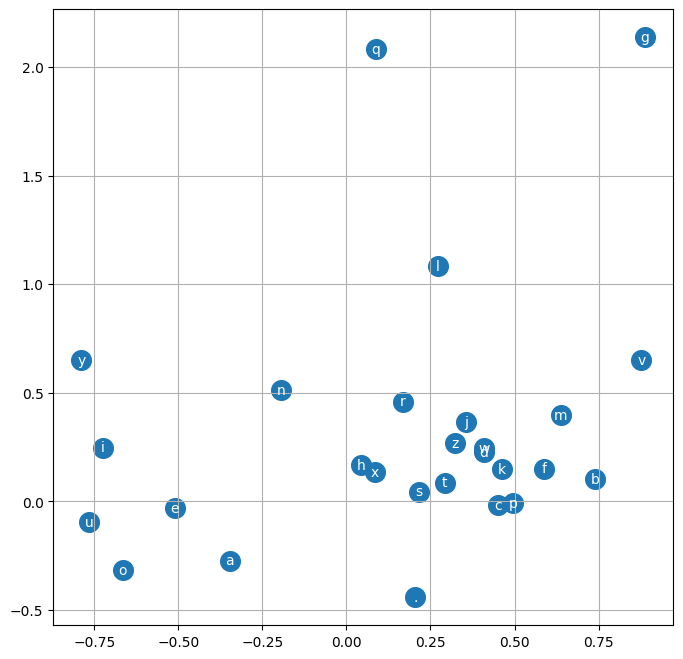

In [68]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center',va='center', color='white')
plt.grid('minor')

#NOW Sample From The Model
###LEts gen some names

In [107]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    contxt = [0] * blocksiz
    while True:
        emb = C[torch.tensor([contxt])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        contxt = contxt[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


montalmyah.
see.
med.
ryla.
reisa.
jendraege.
zeredielin.
shi.
jenre.
eliestanarielleimalke.
miyah.
bergavianel.
kin.
renlynn.
novana.
urzen.
dariyah.
faeh.
yuma.
miskous.
